# Features extraction for ladybug classification
In this notebook, we will extract features from images of ladybugs to classify them into two species. We will use both RGB and segmented images for feature extraction. The main difficulty is avoiding using deep learning techniques and instead relying on easily explainable techniques, so we will implement our own feature extraction.


## I. Loading pictures and data

We will start by loading the images and displaying them.

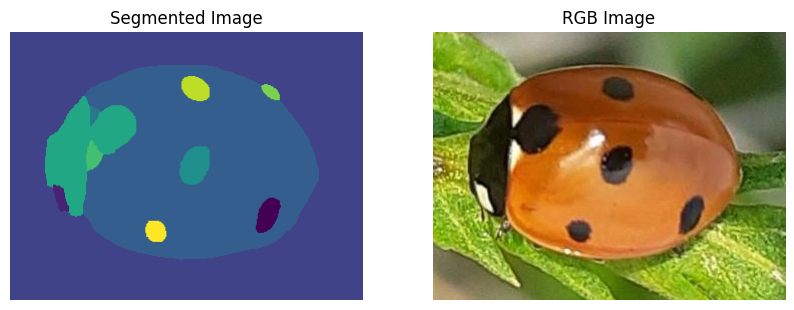

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from random import randint

# Load CSV
labels = pd.read_csv('training_labels.csv')

# Image selection
index = randint(1,201) #Randomly selected to demonstrate the code
imageId = f"im-{index:03d}"

# Load images
def load_image(imageId):
    segmentPath = f"D:/Github/ladybug/ladybug/{imageId}_seg.png"
    rgbPath = f"D:/Github/ladybug/ladybug/{imageId}_im.png"
    labelRow = labels[labels['Image_id'] == imageId]
    labelText = int(labelRow['Label'].values[0])

    indexedImage = Image.open(segmentPath)
    rgbImage = Image.open(rgbPath)
    grayImage = rgbImage.convert("L")  

    return indexedImage, rgbImage, grayImage, labelText

indexedImage, rgbImage, grayImage, labelText = load_image(imageId)

# Display both images side by side
plt.figure(figsize=(10, 5))

#Indexed image
plt.subplot(1, 2, 1)
plt.imshow(indexedImage)
plt.title("Segmented Image")
plt.axis("off")

# RGB image
plt.subplot(1, 2, 2)
plt.imshow(rgbImage)
plt.title("RGB Image")
plt.axis("off")

plt.show()

We will also display convert the RGB image to grayscale and display it alongside the indexed image.
It might be usefull later to extract our features.

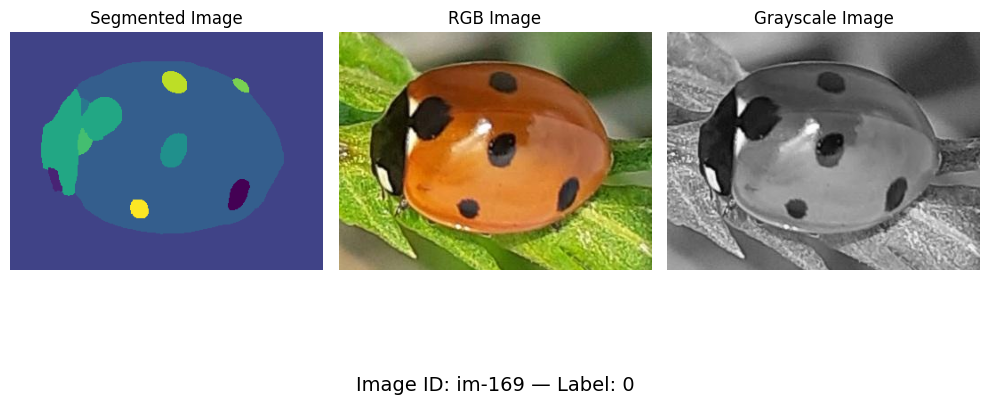

In [90]:
# Display both images side by side
plt.figure(figsize=(10, 5))

#Indexed image
plt.subplot(1, 3, 1)
plt.imshow(indexedImage)
plt.title("Segmented Image")
plt.axis("off")

# RGB image
plt.subplot(1, 3, 2)
plt.imshow(rgbImage)
plt.title("RGB Image")
plt.axis("off")

# Grayscale image
plt.subplot(1, 3, 3)
plt.imshow(grayImage, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.tight_layout()

plt.suptitle(f"Image ID: {imageId} — Label: {labelText}", fontsize=14, y=0.05)
plt.subplots_adjust(wspace=0.05, bottom=0.15, top=0.85)

plt.show()

Now that we have our images displayed, we can think about intereasting features to extract from them.

The first intereasting feature is the color of the ladybug, which can be extracted from the RGB image. Ladybug with a dark shell are always label 1. Another feature is the number of spots, more than 7 is always label 1, exactly 7 is often label 0, and less than 7 can be label 0 or 1, depending on the color of the shell and the angle of the camera (by symmetry we can assume that for some ladybug, they have 7 spots but are not visible from our angle). This are the two main features we will extract from the images.

One another features that could be intereasting to extract but would be more complex would be the two little white spot at the back of the head of the ladybug. When they are present, ladybug are always label 0, so we can use this feature to improve our classification.



# II. Isolating features
 In this section, we will isolate features from the images that could be usefull for classification. The idea is to automate the features extraction and avoid using deep learning, so we can explain the full process. Two of the most obvious features are the number of dot on the ladybug as well as the color of the ladybug. 

 Let's start by removing the background of the image since it does not seems to be relevant.

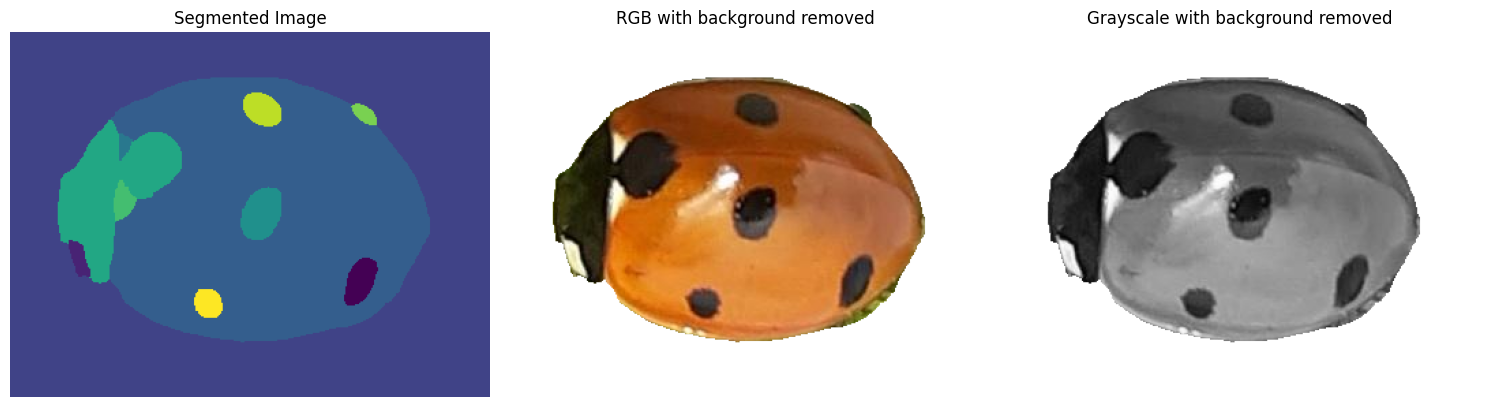

In [91]:
def remove_background(indexedImage, rgbImage, grayImage):
    """
    Remove background from indexed image and create RGBA and LA images.
    """

    indexedArray = np.array(indexedImage)
    rgbArray = np.array(rgbImage)
    grayArray = np.array(grayImage)

    # Get image dimensions
    h, w = indexedArray.shape

    # Get corner values
    topLeft = indexedArray[0, 0]
    topRight = indexedArray[0, -1]
    bottomLeft = indexedArray[-1, 0]
    bottomRight = indexedArray[-1, -1]

    if topLeft == topRight == bottomLeft == bottomRight:
        cornerValue = topLeft

        # Create transparency mask
        mask = indexedArray == cornerValue

        # --- RGBA Image ---
        rgbaArray = np.zeros((h, w, 4), dtype=np.uint8)
        rgbaArray[:, :, :3] = rgbArray  # Copy RGB channels
        rgbaArray[:, :, 3] = 255         # Full opacity
        rgbaArray[mask, 3] = 0           # Transparent where mask is True

        # --- Grayscale with Alpha (LA) ---
        laArray = np.zeros((h, w, 2), dtype=np.uint8)
        laArray[:, :, 0] = grayArray
        laArray[:, :, 1] = 255
        laArray[mask, 1] = 0

        return indexedArray, rgbArray, rgbaArray, grayArray, laArray

indexedArray, rgbArray, rgbaArray, grayArray, laArray = remove_background(indexedImage, rgbImage, grayImage)

# Convert to images
rgbaImage = Image.fromarray(rgbaArray, mode="RGBA")
laImage = Image.fromarray(laArray, mode="LA")

# Display
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(indexedImage)
plt.title("Segmented Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rgbaImage)
plt.title("RGB with background removed")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(laImage)
plt.title("Grayscale with background removed")
plt.axis("off")

plt.tight_layout()
plt.show()

Next, we will extract the color of the ladybug. Since we know that all ladybug with a dark shell are label 1, we will use rgb and grayscale image to determine a threshold that will allow to say if the shell is dark or not. We will work exclusively on the shell so we will use the segmented image to isolate the shell of the ladybug in a similar way as we did for the background. Since ladybug are always in the center of the image, we will select the biggest amount of pixel that would have a center of mass in the center of the image. 

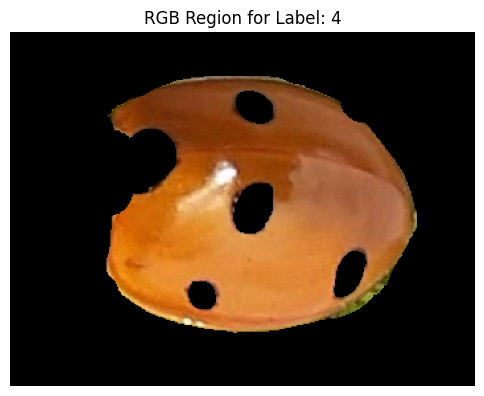

In [92]:
def select_largest_central_object(indexedImg):
    """
    Select the largest non-background object whose center is closest to the image center.

    We compute the center of each labeled region as well as its size and use it to score and select the region that fit the best our criteria.
    
    Parameters:
        indexedImg (np.ndarray): 2D numpy array of labeled regions.
        
    Returns:
        selectedMask (np.ndarray): Boolean mask of the selected region.
        selectedIndex (int): Label of the selected region.
    """
    h, w = indexedImg.shape
    center = np.array([h / 2, w / 2])

    corners = [indexedImg[0, 0], indexedImg[0, -1], indexedImg[-1, 0], indexedImg[-1, -1]]
    backgroundLabel = max(set(corners), key=corners.count)

    selectedIndex = None
    bestScore = None
    selectedMask = None

    for label in np.unique(indexedImg):
        if label == backgroundLabel:
            continue

        mask = (indexedImg == label)
        if not np.any(mask):
            continue

        # Compute centroid
        coords = np.argwhere(mask)
        centroid = coords.mean(axis=0)

        # Compute distance to image center
        distance = np.linalg.norm(centroid - center)

        # Size of the region
        size = coords.shape[0]

        score = (-size, distance)

        if bestScore is None or score < bestScore:
            bestScore = score
            selectedIndex = label
            selectedMask = mask

    return selectedMask, selectedIndex

selectedMask, selectedIndex = select_largest_central_object(np.array(indexedImage))

# Create masked image
maskedRgb = np.zeros_like(rgbArray)
maskedRgb[selectedMask] = rgbArray[selectedMask]

plt.figure(figsize=(6, 6))
plt.imshow(maskedRgb)
plt.title(f"RGB Region for Label: {selectedIndex}")
plt.axis("off")
plt.show()
